# A random data generator

This is an attempt to create a random data generator which will be based on looking at a series of data, trying to fit a distribution curve to that data and then taking the parameters of the probability curve to create a random variate set, `.rvs`, from scipy's stats library.

This document initially looks at creating one working system and then implements it into a function to use with a dataset of storms.

Initially a `numpy.ndarray` is created using `scipy.stats.gamma.rvs` where the paramaters chosen are arbitrary values of `a = 2`, `loc = 1.5`, `scale = 2`, and `size = 10000` as per the example originally shown in `fitter`. The `fitter` funciton is then used to fit the data using `.fit` which gives a range of curves in order of their fitting error, and a plot that shows how effectivly the curves match the data.

,sumsquare_error,aic,bic,kl_div
exponweib,0.003125,1000.930628,-149750.807736,inf
f,0.003130,997.672709,-149732.367131,inf
erlang,0.003133,999.917354,-149733.409856,inf
pearson3,0.003133,999.907520,-149733.370341,inf
chi2,0.003133,999.912620,-149733.237694,inf


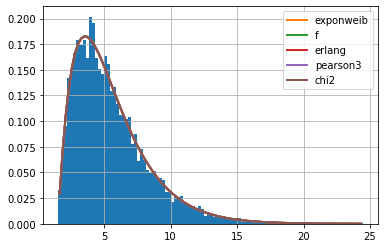

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from fitter import Fitter
# Fit the data using the python fitter library
# https://pypi.org/project/fitter/ 

import random
import warnings
warnings.filterwarnings('ignore')

data = stats.gamma.rvs(2, loc=1.5, scale=2, size=10000)

f = Fitter(data)
f.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions

,sumsquare_error,aic,bic,kl_div
exponweib,0.003125,1000.930628,-149750.807736,inf
f,0.003130,997.672709,-149732.367131,inf
erlang,0.003133,999.917354,-149733.409856,inf
pearson3,0.003133,999.907520,-149733.370341,inf
chi2,0.003133,999.912620,-149733.237694,inf


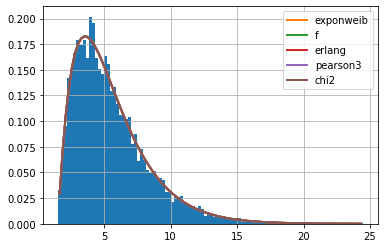

In [12]:
f.summary()

Initially the first curve is taken as it is considered the first best fitting curve and a command is set up using the summary index, or `eval("stats" + dist_df.index[0])` where `dist_df.index[0]` references the scipy curve, to create the random variable set. The parameters for the curve are obtained using the `.fitted_param` function which returns a dictionary whose keys match the summary index values.

Lastly, the `data_len` is taken as the same length of data is what is sought, the length of data created `r_len` is set of `0` and the value `run_once` is set to `False`.

In [2]:
# Return the best fitting curve to the data
dist_df = f.summary(Nbest=1, plot=False)

# Create a command for fitting the distribution 
dist = eval("stats." + dist_df.index[0])

# f.fitted_param gives the fitting characteristics of the different suggested curves.
params = f.fitted_param[dist_df.index[0]]

data_len = len(data)
r_len = 0

run_once = False

print(f"The best fitting curve is {dist_df.index[0]}")

The best fitting curve is exponweib


In order to match the lengths fo data a while loop is set to run with the condition where the length of data does not match the length of new data.

The distribution curves available in scipy can have inputs of 2, 3, or 4 values. A conditional `if` statment is set up to handle these cases and create the random variable set based on the curve. Being a random variable set without min/max conditions means the data created may have some odd values that don't fit within the parameters of the chosen data series. The data series created is then filtered down to have values that exist within the bounds of the original data's min/max values, but this drops values so the new dataset won't match the length of the old dataset. This keeps the while loop running and new data is gathered by calculating the difference between the current data length and the created data length, less the data outside the min/max. The second set of new values created are added to the first set of new values to make the new series the same length as the old series, to break the loop if the new series lies within the min/max bounds of the original data.   

In [3]:
# Probability
while data_len != r_len:
    dist_len = data_len - r_len
    if len(params) == 2:
        print("First condition")
        a, b = params
        r_tmp = pd.Series(dist.rvs(a, b, size = dist_len))

    elif len(params) == 3: 
        print("Second condition")
        a, b, c = params
        r_tmp = pd.Series(dist.rvs(a, b, c, size = dist_len))

    elif len(params) == 4:
        print(f"Third condition {data_len} - {r_len} = {dist_len}")
        a, b, c, d = params
        r_tmp = pd.Series(dist.rvs(a, b, c, d, size = dist_len))

    else:
        print(f"Tom, you're gonna need to make a condition for {dist_df.index[0]}")
        r = pd.Series([np.nan]*dist_len)

    if not run_once:
        run_once = True
        r = r_tmp
    else:
        print(r_tmp)
        r = r.append(r_tmp, ignore_index = True)

    r = r[(data.min() < r) & (r < data.max())]
    r_len = len(r)

Third condition 10000 - 0 = 10000
Third condition 10000 - 9998 = 2
0    3.750761
1    2.276076
dtype: float64


To compare the two distributions the plots of the two datasets can be made to show they're roughtly the same but the slight difference in peaks shows that they're not exactly the same.

Text(0.5, 1.0, 'Data Generated from exponweib')

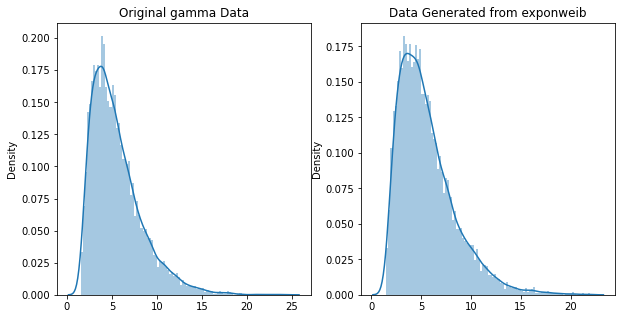

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig1 = plt.figure(figsize = (10, 5))
gs = fig1.add_gridspec(1, 2)

ax = fig1.add_subplot(gs[0,0])
sns.distplot(data, bins=100).set_title(f"Original gamma Data")
ax = fig1.add_subplot(gs[0,1])
sns.distplot(r, bins=100).set_title(f"Data Generated from {dist_df.index[0]}")


The process above is then set into a function to do the same process. 

Some of the issues found were that the method would loop looking for a suitable value so the `runs` variable was added to change the distribution curve and parameters if no suitable random variables can be found.

In [5]:
# From the testing above, create a function to do the same job
def create_random_set(data):
    data_len = len(data)
    data_min = data.min()
    data_max = data.max()
    
    # import and fit the dataset (series) that is to be randomised
    f = Fitter(data)
    f.fit()

    # Return the best fitting curve to the data
    dist_df = f.summary(plot=False)

    r_len = 0
    runs = 0
    # Probability
    while data_len != r_len:
        dist_len = data_len - r_len
        # f.fitted_param gives the fitting characteristics of the different suggested curves
        params = f.fitted_param[dist_df.index[runs]]
        dist = eval("stats." + dist_df.index[runs])

        if len(params) == 2:
            print(f"First condition - {dist_df.index[runs]}")
            a, b = params
            r_tmp = pd.Series(dist.rvs(a, b, size = dist_len))

        elif len(params) == 3: 
            print(f"Second condition - {dist_df.index[runs]}")
            a, b, c = params
            r_tmp = pd.Series(dist.rvs(a, b, c, size = dist_len))

        elif len(params) == 4:
            print(f"Third condition - {dist_df.index[runs]}")
            a, b, c, d = params
            r_tmp = pd.Series(dist.rvs(a, b, c, d, size = dist_len))
            
        elif len(params) == 5:
            print(f"Third condition - {dist_df.index[runs]}")
            a, b, c, d, e = params
            r_tmp = pd.Series(dist.rvs(a, b, c, d, e, size = dist_len))
            
        elif len(params) == 6:
            print(f"Third condition - {dist_df.index[runs]}")
            a, b, c, d, e, f = params
            r_tmp = pd.Series(dist.rvs(a, b, c, d, e, f, size = dist_len))

        else:
            print(f"Tom, you're gonna need to make a condition for {dist_df.index[runs]}")
            r = pd.Series([np.nan]*dist_len)

        if r_len == 0:
            r = r_tmp.astype(np.int64)
        else:
            print(r_tmp.astype(np.int64))
            r = r.append(r_tmp.astype(np.int64), ignore_index = True)
            runs = runs + 1

        r = r[(data_min <= r) & (r <= data_max)]
        r_len = len(r)

    return r

# Use in a dataset

For testing purposes a dataset based on storm data was imported to a dataframe. In this data a series of storms are recorded with their `pressure`, `wind`, and `status` - either `Tropic Depression`, `Tropic Storm`, or `Hurricane`. The storm characteristics are seperated by their `name` and their `status` is defined by the `wind`. A more complex system could be created to define a relationship between `pressure`, `wind`, and `status` but this is merely an example of creating data and not an exercise in meteorolgy. 

Inhereted values might be important considerations to acknowledge when creating new data be it from financial or social media data that sets the base model.

The list of storms that are available are shown below:

In [6]:
storms = pd.read_csv('storms.csv')
storms['name'].unique()

array(['Amy', 'Caroline', 'Doris', 'Belle', 'Gloria', 'Anita', 'Clara',
       'Evelyn', 'Amelia', 'Bess', 'Cora', 'Juliet', 'Ana', 'Bob',
       'Claudette', 'David', 'Frederic', 'Henri', 'Bonnie', 'Charley',
       'Georges', 'Danielle', 'Hermine', 'Ivan', 'Jeanne', 'Karl',
       'Emily', 'Floyd', 'Gert', 'Harvey', 'Katrina', 'Alberto', 'Beryl',
       'Chris', 'Debby', 'Ernesto', 'Alicia', 'Barry', 'Chantal', 'Dean',
       'Arthur', 'Cesar', 'Diana', 'Edouard', 'Gustav', 'Hortense',
       'Isidore', 'Josephine', 'Klaus', 'Lili', 'Danny', 'Fabian',
       'Isabel', 'Juan', 'Kate', 'Andrew', 'AL031987', 'AL061988',
       'Gilbert', 'Isaac', 'Joan', 'Keith', 'Allison', 'Erin', 'Felix',
       'Gabrielle', 'Hugo', 'Iris', 'Jerry', 'Karen', 'Marco', 'Nana',
       'AL041991', 'Erika', 'AL101991', 'AL121991', 'AL021992',
       'AL031992', 'AL081992', 'AL011993', 'AL101993', 'AL021994',
       'AL051994', 'AL081994', 'AL091994', 'AL101994', 'Gordon',
       'AL061995', 'Humberto', 'Lu

And one is randomly selected for the test:

In [8]:
storm_name = random.choice(storms['name'].unique())
storm_selected = storms[storms.name == storm_name]
while len(storm_selected) < 20:
    storm_name = random.choice(storms['name'].unique())
    storm_selected = storms[storms.name == storm_name]
storm_selected.head(10)

,name,year,month,day,hour,lat,long,status,category,wind,pressure,ts_diameter,hu_diameter
4453,Alex,1998,7,27,12,11.3,-25.4,tropical depression,-1,25,1009,NaN,NaN
4454,Alex,1998,7,27,18,11.7,-27.2,tropical depression,-1,25,1009,NaN,NaN
4455,Alex,1998,7,28,0,12.2,-29.2,tropical depression,-1,25,1009,NaN,NaN
4456,Alex,1998,7,28,6,12.6,-31.3,tropical depression,-1,25,1008,NaN,NaN
4457,Alex,1998,7,28,12,12.9,-33.3,tropical depression,-1,30,1007,NaN,NaN
4458,Alex,1998,7,28,18,13.1,-35.1,tropical depression,-1,30,1006,NaN,NaN
4459,Alex,1998,7,29,0,13.3,-36.8,tropical storm,0,35,1005,NaN,NaN
4460,Alex,1998,7,29,6,13.5,-38.5,tropical storm,0,35,1005,NaN,NaN
4461,Alex,1998,7,29,12,13.7,-40.0,tropical storm,0,35,1005,NaN,NaN
4462,Alex,1998,7,29,18,13.9,-41.3,tropical storm,0,35,1005,NaN,NaN


Since a storm is chosen by name and it is of `object` type, its column is superfluous to the current method and can be dropped from the set, while the other object columns are selected, particularly the `status` column.

A dataframe with selected columns is created and an empty dataframe with the same columns. A unique list of object variables is created with respect to the `status` column.

In [9]:
targ_col = ['wind', 'pressure']
col = 'status'
storms2 = storm_selected[targ_col + [col]]
new_storm = pd.DataFrame(columns = storms2.columns)
feat_col = storms2[col].unique() 

The dataframe is filtered for each of the details in the `status` column, and each of the target columns is fed into the `create_random_set` function above as a series so the function can fit to each of the target columns.

In [10]:
for feat in feat_col:
    print(feat)
    storms_tmp = storms2[storms2[col] == feat]
    new_storm_tmp = pd.DataFrame(data = {
        'name': [f'New {storm_name}']*len(storms_tmp),
        col: [feat]*len(storms_tmp)
    })
    for targ in targ_col:
        new_storm_tmp[targ] = create_random_set(storms_tmp[targ])
    new_storm = new_storm.append(new_storm_tmp, ignore_index = True)
        
storms2['name'] = storm_name
storms_joined = storms2.append(new_storm, ignore_index=True)

tropical depression


Second condition - exponpow
Second condition - exponpow
0    25
dtype: int64


Second condition - dgamma
tropical storm


Second condition - exponpow
Second condition - exponpow
0    35
dtype: int64


Second condition - dgamma
hurricane


First condition - arcsine
First condition - arcsine
0    64
dtype: int64
Third condition - ncf
0    98
dtype: int64


Second condition - dgamma


To show the similarities between the two datasets, a scatter plot is graphed showing the original storm and the new storm differentiated by colour, and the storm status defined by marker type.  

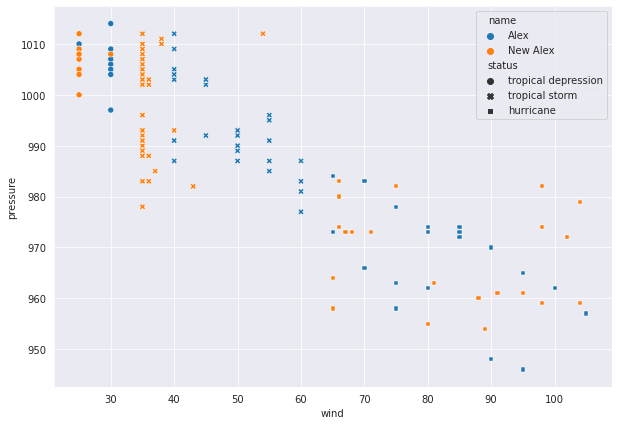

In [11]:
fig2 = plt.figure(figsize=(10,7))
with sns.axes_style("darkgrid"):
    sns.scatterplot(data = storms_joined, x = "wind", y = "pressure", hue="name", style="status")